In [1]:
import torch
import os
from pathlib import Path
import yaml
from yaml.loader import SafeLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from mrnet.networks.mrnet import MRFactory
from mrnet.datasets.sampler import make_grid_coords

from mrnet.training.utils import load_hyperparameters

In [3]:
# Should be the same config file used in the experiment
# In doubt, you can find a copy of this file with the logged results
configpath = input("Path to the hyperparameters config file: ")
hyper = load_hyperparameters(configpath)
print('configpath:', configpath)

Path to the hyperparameters config file:  c:\\Workspace\Neural\mrnet-dev\docs\configs\image.yml


configpath: c:\\Workspace\Neural\mrnet-dev\docs\configs\image.yml


In [4]:
modelpath = input("Path to the saved model parameters file: ")
mrmodel = MRFactory.load_state_dict(modelpath)
print('modelpath:', modelpath)

Path to the saved model parameters file:  c:\\Workspace\Neural\mrnet-dev\runs\M_stg1.pth


modelpath: c:\\Workspace\Neural\mrnet-dev\runs\M_stg1.pth


In [5]:
for p in mrmodel.parameters():
    print("p: ", p.shape, " = ", p.numel())
total_params = sum(p.numel() for p in mrmodel.parameters()) - mrmodel.n_stages()
print("TOTAL = ", total_params)
print("MODEL TOTAL = ", mrmodel.total_parameters())
print("Model type: ", type(mrmodel))

p:  torch.Size([256, 2])  =  512
p:  torch.Size([256])  =  256
p:  torch.Size([256, 256])  =  65536
p:  torch.Size([256])  =  256
p:  torch.Size([3, 256])  =  768
p:  torch.Size([3])  =  3
TOTAL =  67330
MODEL TOTAL =  67330
Model type:  <class 'mrnet.networks.mrnet.MNet'>


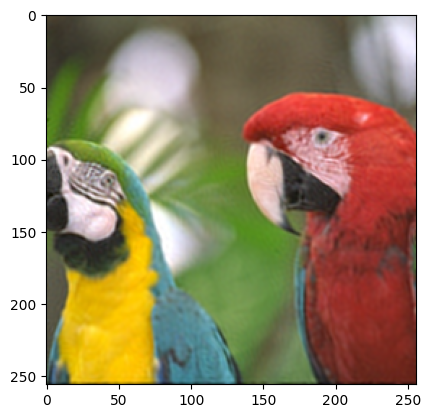

In [6]:
W = hyper['width']
input = make_grid_coords(W, *hyper['domain'], dim=2)
output = mrmodel(input)
model_out = torch.clamp(output['model_out'], 0.0, 1.0)
plt.imshow(model_out.cpu().view(W, W, -1).detach().numpy())

## Extrapolation

In [7]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, Box, interact_manual

In [9]:
slider = widgets.FloatRangeSlider(
    value=[-1.0, 1.0],
    min=-7,
    max=7,
    step=0.1,
    description='Interval:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='50%')
)

model = mrmodel
res = hyper['width']
channels = hyper['channels']
def plot_model(interval):
    grid = make_grid_coords(res, *interval, dim=2)
    output = model(grid)
    model_out = torch.clamp(output['model_out'], 0.0, 1.0)

    pixels = model_out.cpu().detach().view(res, res, channels).numpy()
    pixels = (pixels * 255).astype(np.uint8)
    if channels == 1:
        pixels = np.repeat(pixels, 3, axis=-1)
    return Image.fromarray(pixels)

interact(plot_model, interval=slider)

interactive(children=(FloatRangeSlider(value=(-1.0, 1.0), continuous_update=False, description='Interval:', la…

<function __main__.plot_model(interval)>

## Continuous in Scale

In [10]:
level_slider = widgets.FloatSlider(
        value=1.0,
        min=0.0,
        max=float(mrmodel.n_stages()),
        step=0.05,
        description=f'Multilevel',
        disabled=False,
        continuous_update=True,
        readout=True,
        orientation='horizontal',
        readout_format='.2f',
        layout=widgets.Layout(width='50%')
)
def plot_model(level):
    grid = make_grid_coords(res, -1.0, 1.0, dim=2)
    weights = []
    for s in range(mrmodel.n_stages()):
        if level >= s + 1:
             weights.append(1.0)
        else:
             weights.append(max(level - s, 0.0))

    output = model(grid, mrweights=torch.Tensor(weights))
    model_out = torch.clamp(output['model_out'], 0.0, 1.0)

    pixels = model_out.cpu().detach().view(res, res, channels).numpy()
    pixels = (pixels * 255).astype(np.uint8)
    if channels == 1:
        pixels = np.repeat(pixels, 3, axis=-1)
    return Image.fromarray(pixels)

interact(plot_model, level=level_slider)

interactive(children=(FloatSlider(value=1.0, description='Multilevel', layout=Layout(width='50%'), max=1.0, st…

<function __main__.plot_model(level)>